In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import normaltest
import pickle
import gc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# finbert sentiment data
df = pd.read_pickle('final_m.pkl')

In [4]:
"""whole process for data filtration"""
# # if choose other data
# # set path
# directory = 'the path'

# # get all Parquet file in this path
# parquet_files = [f for f in os.listdir(directory) if f.endswith('.parquet')]

# # read and merge all the Parquet files
# df_list = []
# for file in parquet_files:
#     file_path = os.path.join(directory, file)
#     temp_df = pd.read_parquet(file_path)
#     df_list.append(temp_df)

# df = pd.concat(df_list, ignore_index=True)
#
# # use map table to filter these sentiment data
# map_table = pd.read_pickle('final_map_table.pkl')
# df = pd.merge(combined_df, map_table, on=['id', 'ticker'], how='right')
# df['date'] = [x[:10] for x in df['publishedDate']]
# del combined_df
# gc.collect()

'whole process for data filtration'

In [4]:
df = df[df['date'] >= '2017-08-17']
gc.collect()

0

In [5]:
df

,id,finbert_pos,finbert_neg,finbert_neu,finbert_stmt_score,finbert_stmt_label,publishedDate,ticker,gsector,FAMC,date
1769263,6624480.0,0.031290,0.022326,0.946384,0.008965,neutral,2017-08-31 00,snn,35.0,3185327.60,2017-08-31
1769264,6624480.0,0.031290,0.022326,0.946384,0.008965,neutral,2017-08-31 00,pbh,35.0,268763.00,2017-08-31
1769265,6624483.0,0.029493,0.021830,0.948677,0.007662,neutral,2017-08-31 00,aprn,30.0,22259.64,2017-08-31
1769266,6624483.0,0.029493,0.021830,0.948677,0.007662,neutral,2017-08-31 00,kar,20.0,619311.15,2017-08-31
1769267,6624483.0,0.029493,0.021830,0.948677,0.007662,neutral,2017-08-31 00,baba,25.0,43985190.10,2017-08-31
...,...,...,...,...,...,...,...,...,...,...,...
16129229,47254062.0,0.034132,0.024183,0.941685,0.009949,neutral,2022-09-06 00,imxi,40.0,85245.37,2022-09-06
16129230,47254062.0,0.034132,0.024183,0.941685,0.009949,neutral,2022-09-06 00,blk,40.0,10023694.50,2022-09-06
16129232,47254061.0,0.028153,0.028505,0.943342,-0.000352,neutral,2022-09-06 00,irt,60.0,429241.98,2022-09-06
16129233,47254061.0,0.028153,0.028505,0.943342,-0.000352,neutral,2022-09-06 00,jef,40.0,741283.05,2022-09-06


In [6]:
# counts data
ticker_counts = pd.read_pickle('sNv.pkl').groupby('datadate').apply(lambda x: len(x['tic'].unique()))
ticker_counts_sector = pd.read_pickle('sNv.pkl').groupby(['gsector', 'datadate']).apply(lambda x: len(x['tic'].unique()))
ticker_counts = ticker_counts[(ticker_counts.index >= '2017-08-17') & (ticker_counts.index <= '2022-09-06')]
ticker_counts_sector = ticker_counts_sector[(ticker_counts_sector.index.get_level_values(1) >= '2017-08-17'
                                            ) & (ticker_counts_sector.index.get_level_values(1) <= '2022-09-06')]

In [8]:
ticker_counts

datadate
2017-08-17    2317
2017-08-18    2317
2017-08-21    2318
2017-08-22    2319
2017-08-23    2319
              ... 
2022-08-30    3101
2022-08-31    3102
2022-09-01    3101
2022-09-02    3102
2022-09-06    3102
Length: 1272, dtype: int64

In [7]:
def sentiment_cluster(df_, stock_counts, fin_col, freq='d', impact=3):
    """
    params:
       df_:
       stock_counts:
       fin_col:
       freq:
       impact:
    """
    """ps: 1. some stocks have many news during same period, we should avoid double counting."""
    df_ = df_.copy()
    if freq == 'h':
        freq_col = 'publishedDate'
        stock_counts.name = 'count'
        df_ = pd.merge(df_, stock_counts, left_on='date', right_index=True, how='left')
        stock_counts = df_[['count', freq_col]].drop_duplicates().set_index([freq_col])
    else:
        freq_col = 'date'
    # for the repeated news about the same stock at a certain period, we take the average.
    temp_senti_s = df_.groupby(['ticker', freq_col]).apply(lambda x: x[['finbert_pos', 'finbert_neg', 'finbert_neu']].mean(axis=0))
    # suppose the stocks have no news remain the same sentiment score as last period.
    temp_senti_freq = temp_senti_s.groupby(level=1).mean()
    temp_count_freq = temp_senti_s.groupby(level=1).apply(lambda x: x.shape[0])
    temp_count_freq.name = 'inner_count'
    temp_merge = pd.concat([stock_counts, temp_count_freq, temp_senti_freq], axis=1).sort_index().ffill()
    cluster_dict = {'finbert_pos': [], 'finbert_neg': [], 'finbert_neu': []}
    last_senti = {'finbert_pos': temp_merge.head(1)['finbert_pos'].values[0],
                  'finbert_neg': temp_merge.head(1)['finbert_neg'].values[0],
                  'finbert_neu': temp_merge.head(1)['finbert_neu'].values[0]}
    for ind, row in temp_merge.iterrows():
        for s in ['finbert_pos', 'finbert_neg', 'finbert_neu']:
            temp_put = (row[s] * impact * row['inner_count'] + last_senti[s] * (row['count'] - row['inner_count'])
                           ) / (impact * row['inner_count'] + row['count'] - row['inner_count'])
            
            cluster_dict[s].append(temp_put)
            last_senti[s] = temp_put
    return pd.DataFrame(data=cluster_dict, index=temp_merge.index)


def sector_cluster(df_, stock_counts_sector):
    sec_dict = {}
    for sector, group in df_.groupby('gsector'):
        tc = stock_counts_sector[stock_counts_sector.index.get_level_values(0) == sector].reset_index(level=0, drop=True)
        temp_d = sentiment_cluster(group, tc, 'd')
        sec_dict[sector] = temp_d
    return sec_dict

In [18]:
finbert_cluster = sentiment_cluster(df, ticker_counts)

In [ ]:
see = sector_cluster(df, ticker_counts_sector)

In [113]:
with open('finbert_sentiment_by_sector_dict.pkl', 'wb') as file:  # 打开文件，'wb'表示以二进制写入模式
    pickle.dump(see, file)

In [107]:
data_ = pd.merge(finbert_cluster, sentiment_proxy, left_index=True, right_on='dt')
data_

,finbert_pos,finbert_neg,finbert_neu,dt,close_value
1667,0.231701,0.127091,0.641208,2017-08-17,17
1668,0.199946,0.157277,0.642777,2017-08-18,17
1669,0.207752,0.151814,0.640433,2017-08-21,15
1670,0.225478,0.151798,0.622724,2017-08-22,23
1671,0.229749,0.161087,0.609164,2017-08-23,19
...,...,...,...,...,...
3111,0.270868,0.178095,0.551037,2022-08-12,54
3112,0.213601,0.170581,0.615818,2022-08-13,54
3113,0.258221,0.167054,0.574725,2022-08-15,54
3114,0.282097,0.162461,0.555441,2022-08-16,56


In [297]:
def market_test(sentiment_cluster, sentiment_proxy, column_name_x, column_name_y):
    data_ = pd.merge(sentiment_cluster, sentiment_proxy, left_index=True, right_on='dt')
    data = pd.DataFrame({'x': data_[column_name_x].values, 'y': data_[column_name_y].values})
       
    y_diff = data['y'].copy()
    diff_order_y = 0
    while True:
        y_adf = adfuller(y_diff)
        if y_adf[1] <= 0.05:
            break
        y_diff = y_diff.diff().dropna()
        diff_order_y += 1
        if diff_order_y > 10:  # Prevents infinite loops
            raise ValueError("After several differential scores, the ADF test is still not passed")
            
    x_diff = data['x'].copy()
    diff_order_x = 0
    while True:
        x_adf = adfuller(x_diff)
        if x_adf[1] <= 0.05:
            break
        x_diff = x_diff.diff().dropna()
        diff_order_x += 1
        if diff_order_x > 10:  # Prevents infinite loops
            raise ValueError("After several differential scores, the ADF test is still not passed")
    diff_o = diff_order_x + diff_order_y
    data = pd.DataFrame({'x': x_diff.values[diff_o:], 'y': y_diff.values[diff_o:]})
    # Perform the Granger causality test
    granger_test = grangercausalitytests(data, maxlag=5)
    
    # Fit the VAR model
    model = VAR(data)
    results = model.fit(maxlags=10, ic='aic')  # maxlags is the maximum lag order

    # View the model results
    print(results.summary())
                        
    residuals = results.resid
    for col in residuals.columns:
        print(f'Autocorrelation for {col}:')
        print(adfuller(residuals[col])[1])  # Residuals should not be autocorrelated

    # Residual normality test
    for col in residuals.columns:
        stat, p = normaltest(residuals[col])
        print(f'Normality test for {col}: p-value = {p}')
                        
    return granger_test, results




    
def crypto_test(senti_df, senti_dict, crypto_df):
    crypto_df.index = crypto_df.index.astype(str)
    crypto_df['ret'] = crypto_df['Close'] / crypto_df['Close'].shift()
    crypto_df['future_ret'] = crypto_df['Close'].shift(-5) / crypto_df['Close']
    crypto_df.dropna(inplace=True)
    senti_dict['all'] = senti_df
    
    corr_li = []
    for k in senti_dict.keys():
        print(k)
        sentiment_df = senti_dict[k]
        sentiment_df = sentiment_df.shift().dropna()
        sentiment_df['pos_r'] = sentiment_df['finbert_pos'].rolling(20, min_periods=1).mean()
        sentiment_df['neg_r'] = sentiment_df['finbert_neg'].rolling(20, min_periods=1).mean()
        # Merge Bitcoin price data and sentiment data
        merged_df = pd.merge(btc_d[['ret', 'future_ret']], sentiment_df, left_index=True, right_index=True)

        # Calculate correlations
        # correlation1 = merged_df.corr()['ret']
        correlation2 = merged_df.corr()['future_ret']
        
        X = sm.add_constant(merged_df.drop(['ret', 'future_ret', 'finbert_neu'], axis=1))
        y = merged_df['future_ret']
        model = sm.OLS(y, X).fit()

        # Visualize correlations
        # print(correlation1)
        correlation2.name = k
        corr_li.append(correlation2)
        print(model.summary())
    return pd.concat(corr_li, axis=1)
    
    
def limited_ffill(series, max_fill=5):
    mask = series.isna()
    filled = series.ffill()
    return np.where(mask.cumsum() - mask.cumsum().where(~mask).ffill().fillna(0) <= max_fill, filled, np.nan)
    

def sentiment_strategy(factor, crypto_df, buy_valve, max_fill=5):
    # , sell_valve):
    factor = factor[factor.index.isin(crypto_df.index)]
    crypto_df = crypto_df[crypto_df.index.isin(factor.index)].copy()
    dynamic_valve = np.where((buy_valve > factor.rolling(60).min()), buy_valve, factor.rolling(60).min()) 
    sig_ = np.where((factor <= dynamic_valve), 1, None)
#     sig_ = np.where((factor > sell_valve), 0, sig_)
    crypto_df['sig'] = sig_
    crypto_df['pos'] = limited_ffill(crypto_df['sig'], max_fill)
    # crypto_df['pos'] = crypto_df['sig'].ffill()
    strategy_return = np.where((crypto_df['pos'] == 1), crypto_df['ret'], 1)

    if not isinstance(crypto_df.index, pd.DatetimeIndex):
        crypto_df.index = pd.to_datetime(crypto_df.index)

    plt.figure(figsize=(10, 6))
    plt.plot(crypto_df.index, np.cumprod(strategy_return))

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.title('Sentiment Score Moving Average Strategy Cumulative Return')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()
            
    return np.prod(strategy_return)


def moving_average_strategy(factor, crypto_df, short_window, long_window):
    """
    """
    crypto_df = crypto_df[crypto_df.index.isin(factor.index)].copy()

    short_ma = factor.rolling(window=short_window, min_periods=1).mean()
    long_ma = factor.rolling(window=long_window, min_periods=1).mean()
    
    sig_ = np.where(short_ma > long_ma, 0, 1)
    
    crypto_df['sig'] = sig_
    crypto_df['pos'] = crypto_df['sig'].ffill()
    
    strategy_return = np.where(crypto_df['pos'] == 1, crypto_df['ret'], 1)
    
    plt.figure()
    plt.plot(crypto_df.index, np.cumprod(strategy_return))
    plt.title('Moving Average Strategy Cumulative Return')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.show()

    return np.prod(strategy_return)

In [51]:
sentiment_proxy = pd.read_csv('alexey-formalmethods_fear_greed_data.csv')


In [174]:
finbert_cluster_test = finbert_cluster.copy()
sentiment_proxy_test = sentiment_proxy.copy()
finbert_cluster_test['pos_r'] = finbert_cluster_test['finbert_pos'].rolling(5).mean()
finbert_cluster_test.dropna(inplace=True)
sentiment_proxy_test['close_f'] = sentiment_proxy_test['close_value'].rolling(5).mean()
sentiment_proxy_test.dropna(inplace=True)
_, _ = market_test(finbert_cluster_test, sentiment_proxy_test, 'finbert_pos', 'close_value')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7915  , p=0.1810  , df_denom=1440, df_num=1
ssr based chi2 test:   chi2=1.7952  , p=0.1803  , df=1
likelihood ratio test: chi2=1.7941  , p=0.1804  , df=1
parameter F test:         F=1.7915  , p=0.1810  , df_denom=1440, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1109  , p=0.0023  , df_denom=1437, df_num=2
ssr based chi2 test:   chi2=12.2644 , p=0.0022  , df=2
likelihood ratio test: chi2=12.2125 , p=0.0022  , df=2
parameter F test:         F=6.1109  , p=0.0023  , df_denom=1437, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.8338  , p=0.0001  , df_denom=1434, df_num=3
ssr based chi2 test:   chi2=20.6015 , p=0.0001  , df=3
likelihood ratio test: chi2=20.4556 , p=0.0001  , df=3
parameter F test:         F=6.8338  , p=0.0001  , df_denom=1434, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.5219  , p=0.

<Figure size 1600x600 with 0 Axes>

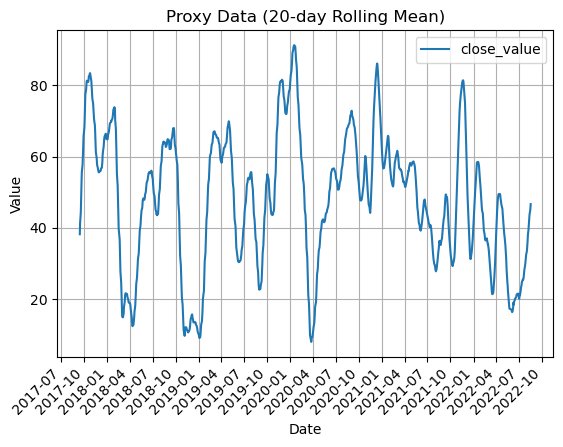

In [293]:

# 确保索引是datetime格式

proxy_df= sentiment_proxy
col = 'finbert_pos'
if not isinstance(finbert_cluster.index, pd.DatetimeIndex):
    finbert_cluster.index = pd.to_datetime(finbert_cluster.index)
if not isinstance(proxy_df['dt'], pd.DatetimeIndex):
    proxy_df['dt'] = pd.to_datetime(proxy_df['dt'])

overlap_time = finbert_cluster[finbert_cluster.index.isin(proxy_df['dt'])].index

# 绘制第一个图形（proxy_df）
plt.figure(figsize=(16, 6))  # 设置第一个图形的大小
proxy_df[proxy_df['dt'].isin(overlap_time)].set_index('dt').rolling(20).mean().plot()

# 设置x轴为年份和月份格式
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 每3个月显示一个刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 显示年份和月份
plt.xticks(rotation=45)  # 旋转x轴标签以便更好地显示
plt.title('Proxy Data (20-day Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

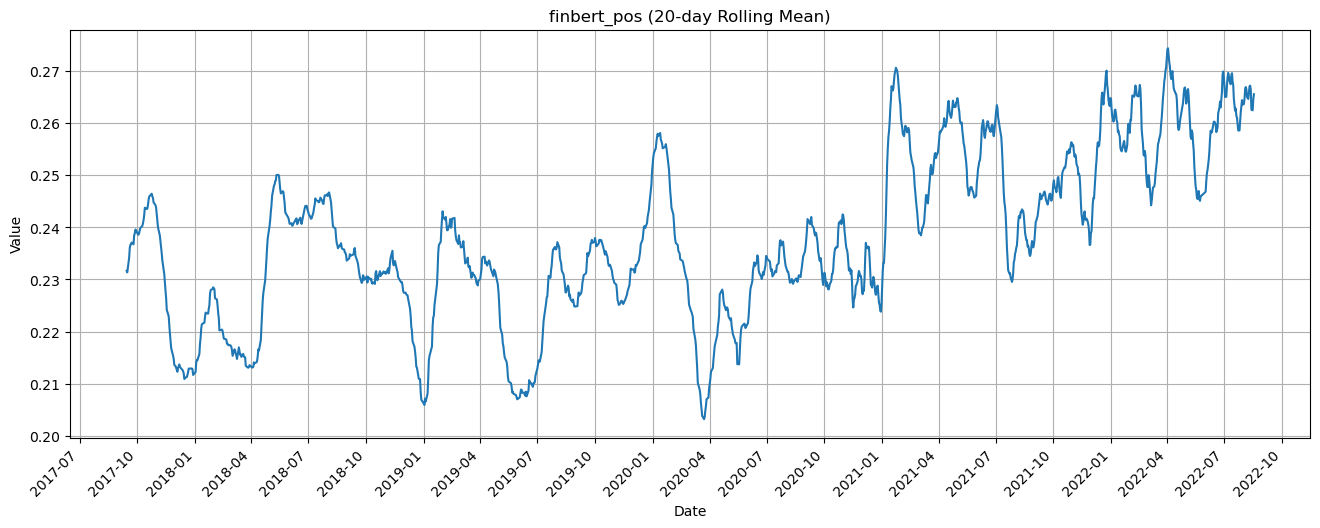

In [294]:
# 绘制第二个图形（df）
plt.figure(figsize=(16, 6))  # 设置第二个图形的大小
finbert_cluster[finbert_cluster.index.isin(overlap_time)][col].rolling(20).mean().plot()

# 设置x轴为年份和月份格式
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 每3个月显示一个刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 显示年份和月份
plt.xticks(rotation=45)  # 旋转x轴标签以便更好地显示
plt.title(f'{col} (20-day Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [188]:
btc_d = pd.read_pickle('cryptos/btc_daily.pkl')

In [222]:
crypto_test(finbert_cluster, see, btc_d)
# 10 pos, 15 pos neu, 20  neu

10.0
                            OLS Regression Results                            
Dep. Variable:             future_ret   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     6.522
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           3.29e-05
Time:                        20:58:08   Log-Likelihood:                 1770.9
No. Observations:                1834   AIC:                            -3532.
Df Residuals:                    1829   BIC:                            -3504.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0966      0.025     43.192 

,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,all
ret,0.019361,0.019361,0.019361,0.019361,0.019361,0.019361,0.019361,0.019361,0.019361,0.019361,0.019361,0.019361
future_ret,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
finbert_pos,-0.084273,-0.087904,-0.056035,-0.057967,-0.018865,-0.054252,-0.073555,-0.032196,-0.019720,-0.036448,-0.056787,-0.075731
finbert_neg,0.007566,-0.043702,-0.074948,-0.009221,-0.049716,-0.050284,-0.019083,-0.041665,0.000753,-0.080840,-0.074137,-0.046686
finbert_neu,0.065205,0.101299,0.099020,0.050902,0.050045,0.082286,0.069790,0.055451,0.014856,0.079015,0.092956,0.088460
pos_r,-0.117092,-0.085487,-0.129672,-0.100145,-0.065329,-0.086140,-0.111446,-0.104298,-0.071917,-0.127683,-0.138460,-0.120741
neg_r,0.032494,-0.064053,-0.091147,-0.014400,-0.081552,-0.078425,-0.014203,-0.096356,-0.016891,-0.135735,-0.041870,-0.054241


In [226]:
factor_test = see[20]['finbert_pos'].rolling(20).mean() + see[60]['finbert_pos'].rolling(20).mean() + see[55]['finbert_pos'].rolling(20).mean()
factor_test.dropna(inplace=True)

In [229]:
factor_test.describe()

count    1827.000000
mean        0.700052
std         0.073139
min         0.556985
25%         0.642518
50%         0.696150
75%         0.752950
max         0.853105
Name: finbert_pos, dtype: float64

In [ ]:
moving_average_strategy(factor_test, btc_d, 5, 20)

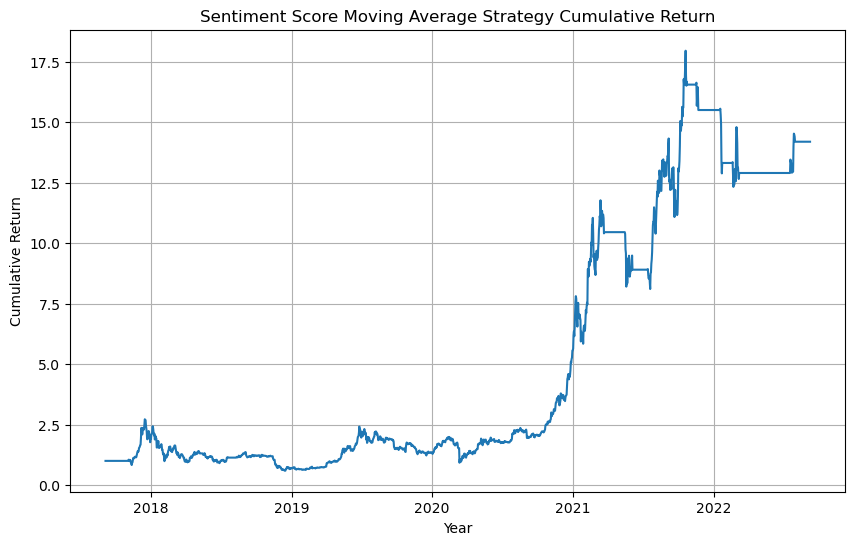

In [302]:
test_r = sentiment_strategy(factor_test, btc_d, 0.75)

In [295]:
doge_d = pd.read_pickle('cryptos/doge_daily.pkl')
doge_d['ret'] = doge_d['Close'] / doge_d['Close'].shift()
doge_d.index = doge_d.index.astype(str)

In [304]:
doge_d = doge_d.dropna()
doge_d

,Open,High,Low,Close,Volume,Close time,Quote volume,Trades,Taker buy base,Taker buy quote,Ignore,ret
Open time,,,,,,,,,,,,
2019-07-06,0.003874,0.003943,0.003365,0.003500,1.010744e+09,2019-07-06 23:59:59.999,3.692804e+06,17250,522724122.00000000,1908499.50964960,0,0.904369
2019-07-07,0.003504,0.003650,0.003400,0.003538,5.306140e+08,2019-07-07 23:59:59.999,1.860353e+06,9394,275110757.00000000,965093.40977300,0,1.010771
2019-07-08,0.003538,0.003562,0.003400,0.003458,3.084457e+08,2019-07-08 23:59:59.999,1.078072e+06,4958,159456967.00000000,558024.17586270,0,0.977471
2019-07-09,0.003462,0.003582,0.003356,0.003455,2.533756e+08,2019-07-09 23:59:59.999,8.785283e+05,5690,115809520.00000000,402047.29506700,0,0.998988
2019-07-10,0.003458,0.003529,0.003251,0.003342,2.412749e+08,2019-07-10 23:59:59.999,8.246233e+05,4797,115599196.00000000,396266.69420690,0,0.967463
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-01,0.201840,0.209000,0.199340,0.206730,7.414343e+08,2025-03-01 23:59:59.999,1.511308e+08,834588,361972123.00000000,73788826.97747000,0,1.024227
2025-03-02,0.206730,0.242180,0.201690,0.239310,2.584480e+09,2025-03-02 23:59:59.999,5.759433e+08,3017121,1300425379.00000000,290081349.95572000,0,1.157597
2025-03-03,0.239300,0.240620,0.193280,0.199130,2.207270e+09,2025-03-03 23:59:59.999,4.735721e+08,3161763,1094107243.00000000,234469655.62468000,0,0.832101


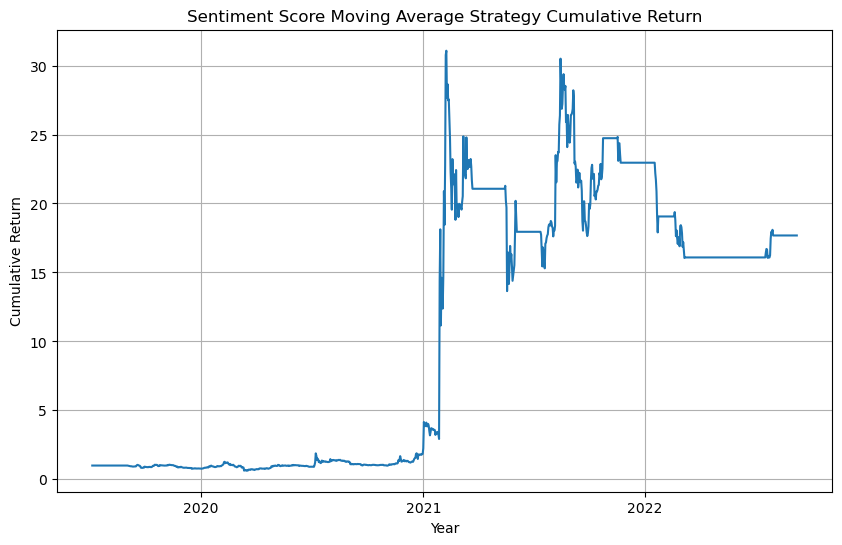

In [309]:
test_doge_r = sentiment_strategy(factor_test, doge_d, 0.75)

In [312]:
sol_d = pd.read_pickle('cryptos/sol_daily.pkl')
sol_d['ret'] = sol_d['Close'] / sol_d['Close'].shift()
sol_d.index = sol_d.index.astype(str)
sol_d = sol_d.dropna()

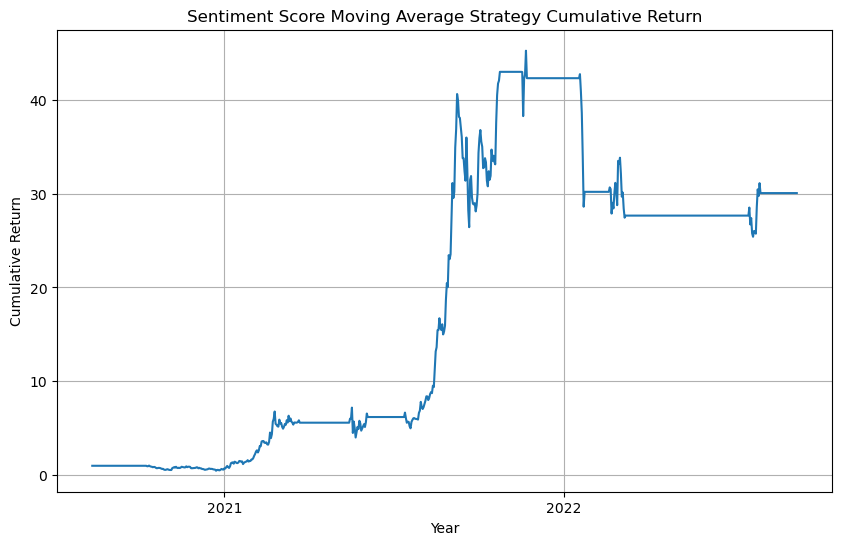

In [320]:
test_sol_r = sentiment_strategy(factor_test, sol_d, 0.75)

In [321]:
eth_d = pd.read_pickle('cryptos/eth_daily.pkl')
eth_d['ret'] = eth_d['Close'] / eth_d['Close'].shift()
eth_d.index = eth_d.index.astype(str)
eth_d = eth_d.dropna()

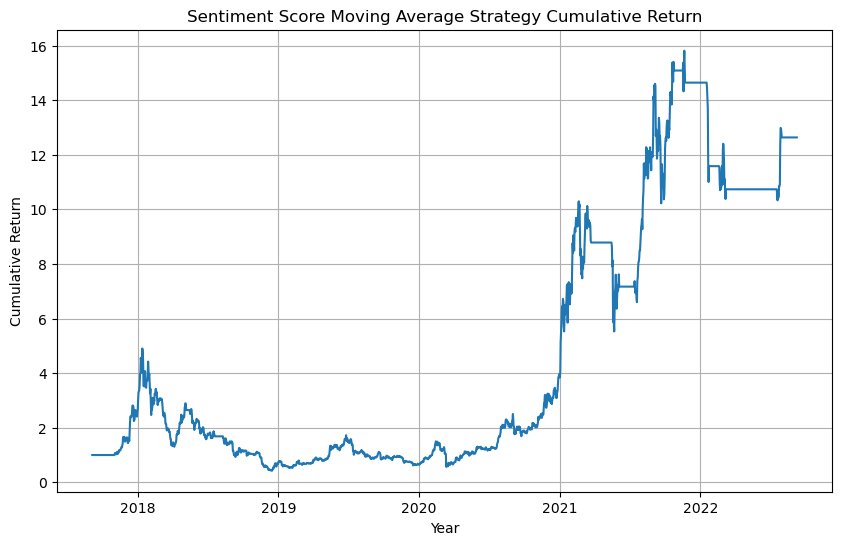

In [322]:
test_eth_r = sentiment_strategy(factor_test, eth_d, 0.75)